In [2]:
# load libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wrds
%matplotlib inline

In [3]:
# functions that we will use in this notebook that you don;t need to worry about for now

def get_daily_wrds_single_ticker(ticker,conn,dividends=True):
    tickers = [ticker]
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = [permnos['permno'].unique().tolist()[0]]
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
    # Pivot data to have dates as index and tickers as columns
    # daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
    # daily_returns=daily_returns['2000':]
    if dividends:
        daily_returns['D']=(daily_returns.ret-daily_returns.retx)*daily_returns.prc.abs().shift(1)
        daily_returns['P']=daily_returns.prc.abs()
        daily_returns=daily_returns[['date','P','D']].set_index('date').dropna()
    else:
        daily_returns=daily_returns[['date','ret']].set_index('date').dropna()    


    return daily_returns


def get_daily_wrds_multiple_ticker(tickers,conn):
  
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
    # Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret').dropna()    
    daily_returns=daily_returns[tickers]



    return daily_returns


# tickers = ['UNH']
# # Retrieve PERMNOs for the specified tickers
# permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
# permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
# permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]

# # Extract unique PERMNOs
# permno_list = permnos['permno'].unique().tolist()

# # Query daily stock file for the specified PERMNOs
# query = f"""
#     SELECT permno, date, ret,       
#     FROM crsp.dsf
#     WHERE permno IN ({','.join(map(str, permno_list))})
#     ORDER BY date
# """
# daily_returns = conn.raw_sql(query, date_cols=['date'])
# daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# # Pivot data to have dates as index and tickers as columns
# daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
# daily_returns=daily_returns['2000':]




# Returns, excess returns, and common factors




* Define what are returns, which is the key variable of analysis in finance (and this class).
* Discuss how to think them of random variables 
* Discuss the key statistical "moments" that we will use to capture their behavior (i.e. how risky they are)
* Discuss the normal distribution specifically
* Define the concept of Excess returns



## What is a return?


* Lets say you paid $𝑃_𝑡$ in date $t$ for an asset

* In date $t+1$ the price is $𝑃_{𝑡+1}$  and you earn some dividend as well $𝐷_{𝑡+1}$

* Then we say that your return is

$$𝑅_{𝑡+1}=\frac{𝑃_{𝑡+1}+𝐷_{𝑡+1}−𝑃_𝑡}{𝑃_𝑡}$$

* It is the gain you made (everything that you go in date t+1), divided by how much you put in ( the price of the asset)


* This definition works for ANY asset that has a positive price

* This is the case for stocks, bonds, commodities, crypto, most real assets

* The return simply normalizes the "dollar gain" by the cost of the asset. 

* In practice there are many types of distributions that are economically like a dividend but have different names: cash dividends, stock dividends, capital gain distributions, rights offerings, acquisition  related distributions, splits

Lets start by loading Price and Dividend data on a single stock


In [4]:
conn = wrds.Connection()
df_UNH=get_daily_wrds_single_ticker('UNH',conn)
df_UNH

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
[92655]


,P,D
date,,
1984-10-18,4.87500,0.0
1984-10-19,4.68750,0.0
1984-10-22,4.68750,0.0
1984-10-23,4.56250,0.0
1984-10-24,4.68750,0.0
...,...,...
2023-12-22,520.31000,0.0
2023-12-26,520.03003,0.0
2023-12-27,522.78998,0.0


In [5]:
#How do we construct returns?


df_UNH['ret']=(df_UNH['P']+df_UNH['D'])/df_UNH['P'].shift(1)-1

df_UNH

,P,D,ret
date,,,
1984-10-18,4.87500,0.0,NaN
1984-10-19,4.68750,0.0,-0.038462
1984-10-22,4.68750,0.0,0.000000
1984-10-23,4.56250,0.0,-0.026667
1984-10-24,4.68750,0.0,0.027397
...,...,...,...
2023-12-22,520.31000,0.0,0.000827
2023-12-26,520.03003,0.0,-0.000538
2023-12-27,522.78998,0.0,0.005307


In [50]:
df_UNH['ret'].mean()

0.0009104234710832472

If I have invested 100 dollars in a random month in the sample, on average I would have 100.09 in month t+1 in the sample

A return of

$$\frac{100.09-100}{100}=0.09\%$$

Suppose that at the start of the sample we invested 1 dollar in this stock and got all the dividends and used to buy more of the stock, 

* how many dollars we would have at the end of the sample?

* What is the cumulative return on our investment?

* What is the annualized return?

* What is the dividend yield?




134.59749454136372
133.59749454136372
0.13320600988316555


<Axes: xlabel='date'>

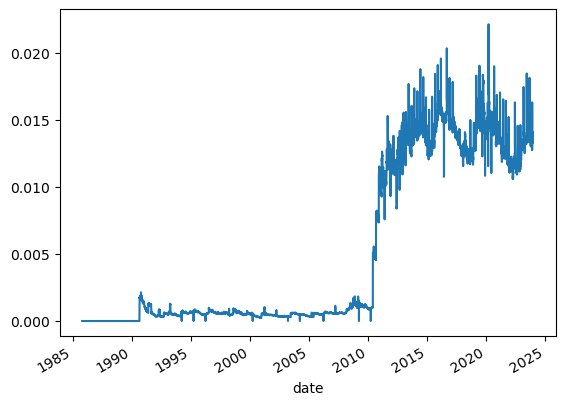

In [6]:
print((df_UNH['ret']+1).prod())

print((df_UNH['ret']+1).prod()-1)


print((df_UNH['ret']+1).prod()**(252/df_UNH.shape[0])-1)


(df_UNH.D.rolling(252).sum()/df_UNH.P).plot()

Suppose we are now at the end of the sample 

1. You have 1000 dollars invested in this stock in the end of the sample, the next day there’s a 16% chance your portfolio's value will fall below a certain amount. How would you estimate that value?

1. Now suppose you want to know this value in one year? What is your estimate of this value?

1. What is the expected value of your holdings in one year? How should you think about estimating this?

1. What can you plot  to have a sense of the distribution of 1 day returns? And 1 year 
returns?

1. What plot can you to give you a sense of these returns varying over time?

1. What drives these returns? Why do they vary over time?



## Decomposing Returns

* Returns of an individual stock can be driven by many things
  - Time-value of money. There are periods where you can get very high returns even in perfectly safe assets
  - Common factors, examples: all stocks went up because of a stronger economy, all stocks went down because of a financial crisis
  - Individual factors impacting the stock: A new drug/a new technology that the firm sells. Anything specific to the firm

When investing is essential to understand where you are performance comes from

We will build towards a framework of investing that thinks differently about investing on systematic risk and idiosyncratic risk

The first step will be to build this decomposition, which will start now and culminate in our factor models lecture

### Striping the risk-free rate


* In this class we will do a lot of decomposing, but lets start by stripping down the "time-value of money" piece

* We first define an "<b>excess return</b>"： the return minus the risk-free rate 
 
 $$excess~return^{stock~i}=return^{stock~i}-risk~free~rate$$
 
* We typically use the returns of a 3-month treasury bill to measure the risk-free rate

* We will denote $rf$ for the risk-free rate

* We often add superscript e to denote an excess return. 

* so if $r^i$ stands for the return of stock $i$, then $r^{e,i}$ is it's excess return

* Conceptually you want to use the risk-free asset for the relevant holding period you are evaluating the asset returns, but for this class you can think of the "Fed Funds Rate" or the "3-month treasury-bill rate"


<Axes: xlabel='Date'>

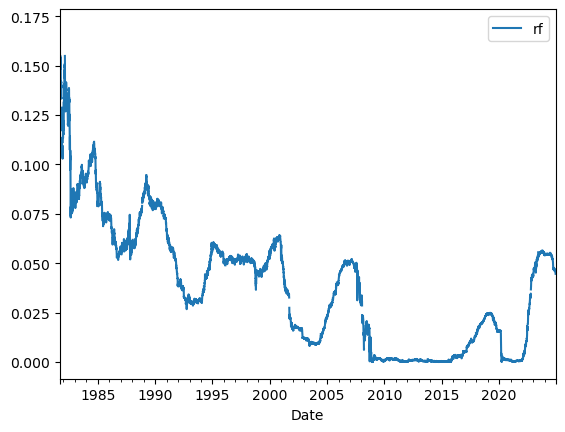

In [7]:
from pandas_datareader.data import DataReader
import datetime

# Define the date range
start_date = datetime.datetime(1960, 1, 1)  # Start date (adjust as needed)
end_date = datetime.datetime.now()          # End date

# Fetch the data from FRED for 3-month Treasury Bill rates (symbol: DGS3MO)
try:
    df_rf = DataReader("DGS3MO", "fred", start_date, end_date)
    df_rf.reset_index(inplace=True)
    df_rf.columns = ["Date", "rf"]
    df_rf.rf=df_rf.rf/100
    df_rf.set_index("Date", inplace=True)
except Exception as e:
    print(f"An error occurred: {e}")

df_rf.plot()

How do we interpret this rate?

Say if I invested in the tbill in 2005 how much money I would have in the end of 3 months? And in the end of the year?



Lets get another stock to play with and merge it together with our risk-free return


In [8]:
df=get_daily_wrds_single_ticker('NVDA',conn,dividends=False)
df=df.merge(df_rf, left_index=True, right_index=True,how='left')
df

[86580]


,ret,rf
date,,
1999-01-25,0.104762,0.0444
1999-01-26,-0.077586,0.0446
1999-01-27,-0.003115,0.0447
1999-01-28,-0.003125,0.0449
1999-01-29,-0.047022,0.0448
...,...,...
2023-12-22,-0.003266,0.0544
2023-12-26,0.009195,0.0545
2023-12-27,0.002800,0.0544


Lets construct another column called 'ret_e' for excess returns

What is the trading interpretation of such series?

Is it the "return" to which strategy exactly?

- How the historical distributions of ret and rete compare?
- Are their averages similar? 
- are their historical standard deviations  similar? 
- Do they have similar interpretation? 
- Is the standard-deviation of risk-free rate useful to tell you the distribution of you returns in the end of 3 months? 

## Risk Premiums

- We call the risk-premium what we earn in excess of what a risk-free investment pays
- So the risk premium of an asset is the expected value of the excess return

$$risk~premium~of~stock~i=E[r^{e,i}]$$

So the expected return of a stock is

$$E[r^i]=rf+E[r^{e,i}]$$


The realized return is obviously volatile, hence the risk

$$u_i=r^{e,i}-E[r^{e,i}]$$

will be negative 50% of the time and sometimes quite negative!

Big picture level the goal of quant investing is to harvest these risk-premia while managing the risk

- We know the risk-free rate (it is the yield on a short-term government bond)

- How do we figure out the risk-premium of an asset?



### Stripping the common factor

- We will build a simple model to help us both think about this risk-premium and also the risk that we need to manage

- It will be useful to decompose the excess returns further to better understand it's risk and it's premium

- We know that the overall market portfolio moves around, so it is natural to strip that market-wide movement from the stock returns

- Suppose f is this common factor, one possibility is to write

$$r^{i}=r^i-rf+rf$$

$$r^{i}=r^i-rf+rf-f+f$$

Reorganizing we have that the return can be written as

$$r^{i}=rf+f+r^{e,i}-f$$

$$r^i=risk~free~rate(rf)+factor(f)+firm~specific~component (r^{e,i}-f)$$


- What is this common factor? 

- Will this work? When will it work?




* I will use the returns on the SPY etf as a market proxy, i.e

$$f=return^{SPY}$$

* This funds holds a market-capitalization weighted portfolio of the largest 500 US stocks (roughly)--this consists of about 85% of the total universe of investable US equities

* The press often cites the DOW JONES as another proxy for the overall movement in stocks--but it is a terrible proxy, since is a equal weighted portfolio of 30 arbitrary chosen stocks. Please never ever use that

* If you really want to use a portfolio that tracks the entirety of the US stock market universe you can use VTI which is a ETF that holds market-capitalization weighted portfolio of all publicly traded US stocks. About 60 Trillion investment universe

* For reasons that will be clear later--but don;t matter for now, I will also strip the risk-free rate from our common factor

$$f=return^{SPY}-rf$$

- Is there only one factor?

- What other factors beyond the market comes to mind?

In [77]:
#conn = wrds.Connection()
df=get_daily_wrds_multiple_ticker(['SPY','WMT','JPM'],conn)
#Why did I divide by 252?
df=df.merge(df_rf/252, left_index=True, right_index=True,how='left')
df

[47896, 55976, 84398]


,SPY,WMT,JPM,rf
date,,,,
1993-02-01,0.007112,0.011516,0.009231,0.000119
1993-02-02,0.002119,0.005693,0.003049,0.000120
1993-02-03,0.010571,0.009434,0.012158,0.000119
1993-02-04,0.004184,-0.003738,0.012012,0.000117
1993-02-05,-0.000694,-0.011257,0.017804,0.000117
...,...,...,...,...
2023-12-22,0.002010,0.011951,-0.000597,0.000216
2023-12-26,0.004223,-0.001532,0.005914,0.000216
2023-12-27,0.001808,0.009398,0.005998,0.000216


In [78]:
# will create excess retursn

df_re=df.drop(columns='rf').sub(df['rf'],axis=0)
df_re

,SPY,WMT,JPM
date,,,
1993-02-01,0.006993,0.011397,0.009112
1993-02-02,0.001999,0.005573,0.002929
1993-02-03,0.010452,0.009315,0.012039
1993-02-04,0.004067,-0.003855,0.011895
1993-02-05,-0.000811,-0.011374,0.017687
...,...,...,...
2023-12-22,0.001794,0.011735,-0.000813
2023-12-26,0.004007,-0.001748,0.005698
2023-12-27,0.001592,0.009182,0.005782


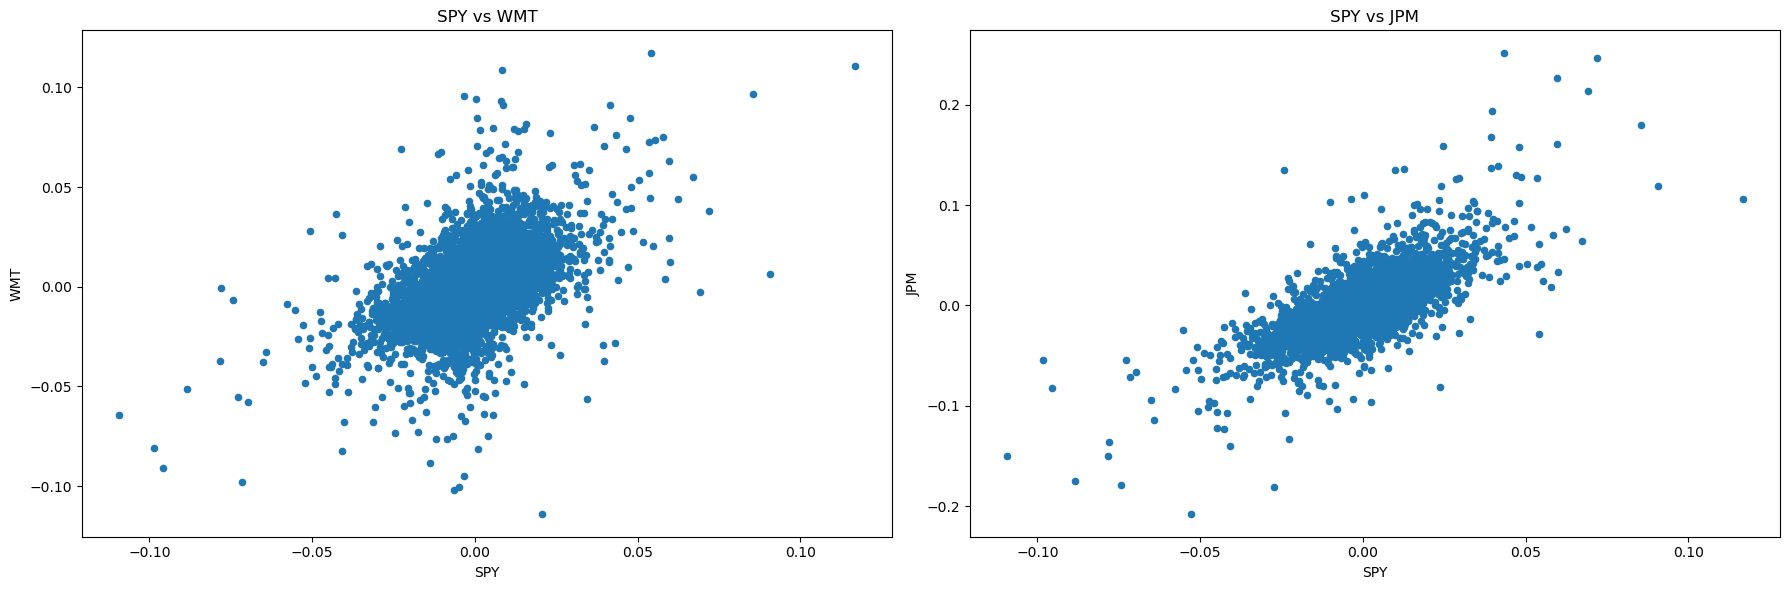

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.api as sm


# Function to add regression line and beta coefficient

df_re.plot.scatter(x='SPY', y='WMT', ax=axes[0], title='SPY vs WMT')

# Scatter plot for SPY vs CSCO
df_re.plot.scatter(x='SPY', y='JPM', ax=axes[1], title='SPY vs JPM')

plt.tight_layout()
plt.show()

Indeed we see quite a bit of co-movement!

Days that SPY return is up, Both stocks tend to be up as well

Another way of see this is looking at the correlation between the stocks and the factor

In [81]:
df_re.corr()

,SPY,WMT,JPM
SPY,1.000000,0.496421,0.711185
WMT,0.496421,1.000000,0.328472
JPM,0.711185,0.328472,1.000000


Lets try to clean the stock from exposure to the common factor by subtracting it out

'm_spy' denote the returns minus the return on the factor



In [ ]:
df_re[['WMT_m_spy','JPM_m_spy']]=df_re[['WMT','JPM']].subtract(df['SPY'],axis=0)
df

ticker,SPY,WMT,JPM,WMT_m_spy,JPM_m_spy
date,,,,,
1993-02-01,0.007112,0.011516,0.009231,0.004404,0.002119
1993-02-02,0.002119,0.005693,0.003049,0.003574,0.000930
1993-02-03,0.010571,0.009434,0.012158,-0.001137,0.001587
1993-02-04,0.004184,-0.003738,0.012012,-0.007922,0.007828
1993-02-05,-0.000694,-0.011257,0.017804,-0.010563,0.018498
...,...,...,...,...,...
2023-12-22,0.002010,0.011951,-0.000597,0.009941,-0.002607
2023-12-26,0.004223,-0.001532,0.005914,-0.005755,0.001691
2023-12-27,0.001808,0.009398,0.005998,0.007590,0.004190


What is the trading interpretation in this case? What is the portfolio that yields the 'ret_m_spy' payoff?

What is the cost of implementing this portfolio? Say you want to have a 100 dollar exposure to it?

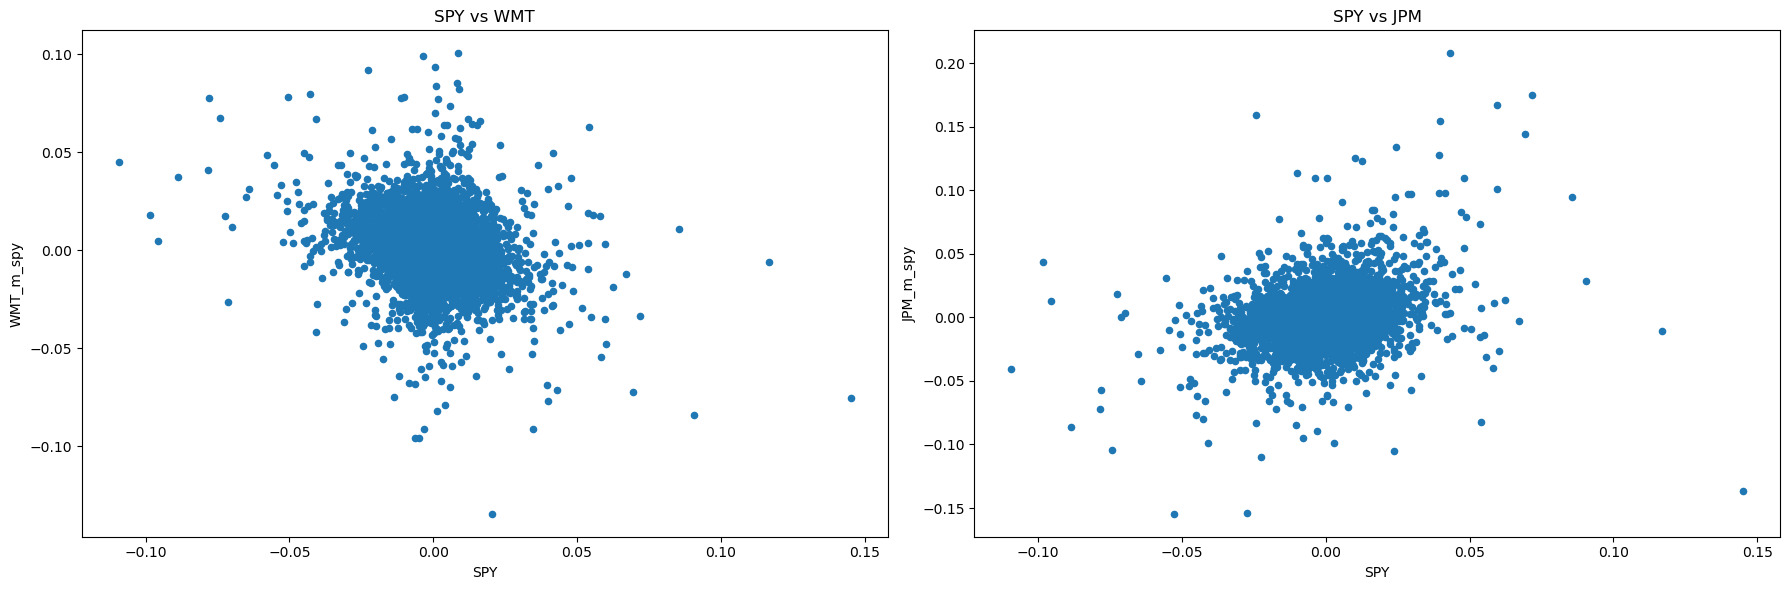

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.api as sm


# Function to add regression line and beta coefficient

df_re.plot.scatter(x='SPY', y='WMT_m_spy', ax=axes[0], title='SPY vs WMT')

# Scatter plot for SPY vs CSCO
df_re.plot.scatter(x='SPY', y='JPM_m_spy', ax=axes[1], title='SPY vs JPM')

plt.tight_layout()
plt.show()

Did it work?



In [ ]:
df_re.corr().loc['SPY',:]

ticker
SPY          1.000000
WMT          0.497637
JPM          0.704236
WMT_m_spy   -0.266299
JPM_m_spy    0.261074
Name: SPY, dtype: float64

In [ ]:
df_re.std()

ticker
SPY          0.011813
WMT          0.016023
JPM          0.023062
WMT_m_spy    0.014418
JPM_m_spy    0.016962
dtype: float64

What is going on?

The "model" motivating our decomposition was

$$ r=r-rf-f+f+rf$$

with the $r-f-rf$ picking up the stock specific movement and $f$ the common movement

But it seems that the residual still has factor exposure

* For stock 1, the residual is negatively correlated, so it seems tha we are taking out too much
* For stock 2, it is still positive, so we are taking out too little 
* Taking out 1 dollar of factor exposure for each 1 dollar of stock exposure reduced the factor exposure and the asset volatilities, but we can do better


## Towards a factor Model

- First idea is that stocks might have different degree of co-movement
- For example, Defensive stocks like utilities, supermarkets, and so on might not suffer as much when the market tanks
    - Their cash flow might be more recession proof for example
    - While luxury good producers like LMVH might be more sensitive to the stock market given its consumer base
- Small stocks, stocks with high leverage and so one might particularly suffer during economic busts



$$(excess~return)=(intercept)+(stock~beta)*(factor~excess~return)+ (idio~risk)$$




beta of asset WMT is 0.6749692108883036
the "intercept" of asset WMT is 0.04522121157501705 annualized
beta of asset JPM is 1.374860222270463
the "intercept" of asset JPM is 0.023283503662360792 annualized


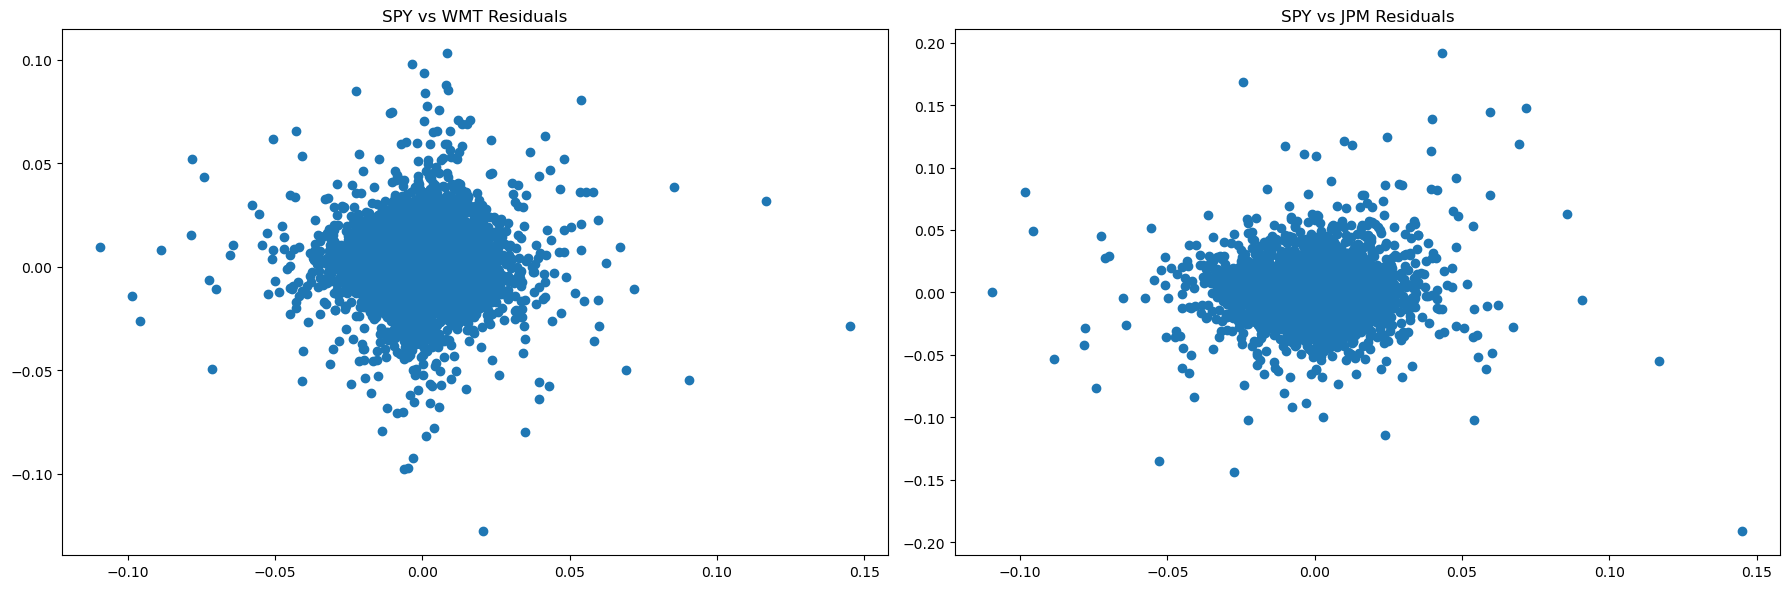

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.api as sm

factor='SPY'
asset='WMT'    
X = sm.add_constant(df_re[factor])
model = sm.OLS(df_re[asset], X).fit()
intercept_wmt, beta_wmt = model.params
print(f'beta of asset {asset} is {beta_wmt}')


axes[0].scatter(x=df_re['SPY'], y=(df_re['WMT']-beta_wmt*df_re['SPY']))
axes[0].set_title('SPY vs WMT Residuals')

factor='SPY'
asset='JPM'    
X = sm.add_constant(df_re[factor])
model = sm.OLS(df_re[asset], X).fit()
intercept_jpm, beta_jpm = model.params
print(f'beta of asset {asset} is {beta_jpm}')


axes[1].scatter(x=df_re['SPY'], y=df_re['JPM']-beta_jpm*df_re['SPY'])
axes[1].set_title('SPY vs JPM Residuals')

plt.tight_layout()
plt.show()


Did it work?

- With the regression we have a statistical decomposition
- At least in sample, the regression guarantees that the stock specific component is completely orthogonal to the factor

$$stock~specific~component=(excess~return)-(stock~beta)*(factor~excess~return)$$

In [ ]:
df_re[['SPY']].corrwith(df_re['JPM']-beta_jpm*df_re['SPY'])



ticker
SPY    1.656269e-16
dtype: float64

In [ ]:
df_re[['SPY']].corrwith(df_re['WMT']-beta_wmt*df_re['SPY'])

ticker
SPY    5.141267e-17
dtype: float64


- $\beta$ , that is beta, measures factor exposure and together with the factor variance, it tells us the amount of factor risk in the asset
- $\epsilon$ is the idiossyncratic, non-factor risk component of the asset--all the risk that is leftover after we take out the co-movement with the factor
- intercept is going to be very important
- We will discuss this later in detail 

How do we estimate the amount of idiossyncratic risk?

How do we estimate the amount of systematic risk?



In [ ]:
print(f'the historical variance of asset {asset} idio risk is {model.resid.var()*252} annualized')

print(f'the historical standard deviation of asset {asset} idio risk is {model.resid.std()*252**0.5} annualized')


print(f'the historical variance of the market factor is {df_re.SPY.var()*252} annualized')
print(f'the historical standard deviation of the market factor is {df_re.SPY.std()*252**0.5} annualized')

the historical variance of asset JPM idio risk is 0.06755883655421582 annualized
the historical standard deviation of asset JPM idio risk is 0.25992082747293616 annualized
the historical variance of the market factor is 0.035166377478007854 annualized
the historical standard deviation of the market factor is 0.18752700466334934 annualized


Can we say what share of the stock variance is due the market risk factor?

What is the calculation?

> ### Takeaways
>- How to construct returns from prices and dividends
>- How to use moments of the return distribution to think about what you expect in the future
>- We learn about risk-premiums 
>- We learned how to decompose an asset risk into a factor component and an asset specific component
>- We learned how to decompose the amount of variance is coming from each of these componenents
